In [60]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import re
from numpy import *  
import matplotlib.pyplot as plt
import numpy as np
import glob
import operator
import pickle
import nltk
from string import digits 

from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [2]:
df = pd.read_csv('../data/jigsaw-toxic-comment-classification-challenge/train.csv')
df.sample(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
28482,4b684cef8a6befaa,"""\nIf you are going to write an article about ...",0,0,0,0,0,0
133259,c8f696ce3474999c,Username \nYou might want to become a register...,0,0,0,0,0,0
48068,8069862139cadd98,Where can I find kellers star ratings 142.162....,0,0,0,0,0,0
100752,1b41c1c4b0caecbd,then don't live with it! Screw YOUR TYRANNY ...,1,0,0,0,0,0
115219,68137893e71c9e4c,"""|decline=You have asked for guidance - it is ...",0,0,0,0,0,0


# Exploration

In [8]:
df.shape

(159571, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


Total of comments,  159571
Total number of non toxic comments:  143346
Total number of toxic comments:  16225


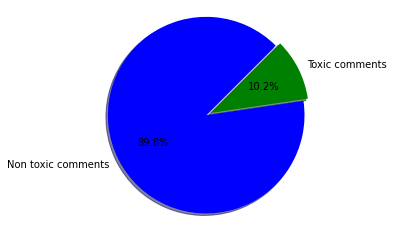

In [36]:
row_sums=df.iloc[:,2:].sum(axis=1)
non_toxic =(row_sums==0)
toxic=len(df)-non_toxic.sum()

print("Total of comments, ",len(df))
print("Total number of non toxic comments: ", non_toxic.sum())
print("Total number of toxic comments: ", toxic)

labels = ['Non toxic comments', 'Toxic comments']
sizes = [non_toxic.sum(),toxic]
colors = ['blue', 'green']
# Data to plot
explode = (0, 0.05)  # explode 1st slice

# Plot
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=45)

plt.axis('equal')
plt.show()

In [37]:
print("Number of rows with multiple labling: ", (rowsums > 1).sum())

Number of rows with multiple labling:  9865


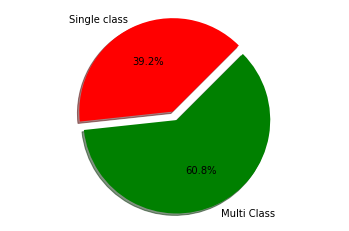

In [83]:
multiclass=(rowsums > 1).sum()
# Plot
plt.pie([toxic.sum()-multiclass,multiclass], explode=(0,0.1), 
        labels=['Single class', 'Multi Class'], colors=['red', 'green'], autopct='%1.1f%%', 
        shadow=True, startangle=45)
plt.axis('equal')
plt.show()

Over the half of the toxic comments are multiclass with two or more toxic classifications   
We are going to spli the data set in toxic and no toxic comments, with a new column, and the rest of the columns to describe toxicity will be deleted

In [40]:
df.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [174]:
def typeComment(df):
    # If the comment has value more than 0, then it is  toxic. Otherwise non-toxic
    score=list(df.sum(axis = 1, skipna = True))
    new_score = [1 if (x>0) else 0 for x in score]
    return(new_score)
df['Toxic'] = typeComment(df)
toxic_columns=['toxic','severe_toxic','obscene','threat','insult','identity_hate']
df = df.drop(columns=toxic_columns)
df.sample(5)

,id,comment_text,Toxic
140418,ef636ecedd1745ea,will you be my friend?,0
119373,7e334eae358e054d,"""\n\nBiography vs. movie plot\n""""The shorter b...",0
101444,1ef188102237ecec,Really? Ya don't say? Who'd a thunk?,0
72708,c286397e5ca92e64,"""\n\n Concerning the 1-week block decision by ...",0
50566,8737ff5c3cfab59b,Illegal \n\nYou guys need to remove this page....,0


In [78]:
def makingClasses(df):
    toxic = df[df.Toxic == 1]
    non_toxic = df[df.Toxic == 0]
    total_data = len(df)
    def printDFrame(name, frame, total_data):
        print(name + ": " + str(frame.shape[0]) + " " + str(frame.shape[0]/total_data * 100) + "%")
    p = printDFrame
    p("Toxic", toxic, total_data)
    p("Non toxic", non_toxic, total_data)
    return toxic, non_toxic

In [131]:
toxic, non_toxic = makingClasses

Toxic: 16225 10.167887648758233%
Non toxic: 143346 89.83211235124176%


In [132]:
non_toxic=non_toxic.sample(len(toxic))

## Distribution of capital letters

In [159]:
T_words = toxic['comment_text'].apply(lambda comment: 
                                           sum(1 for c in comment if c.isupper())/len(comment.split())) 
N_words = non_toxic['comment_text'].apply(lambda comment: 
                                          sum(1 for c in comment if c.isupper())/len(comment.split())) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  after removing the cwd from sys.path.


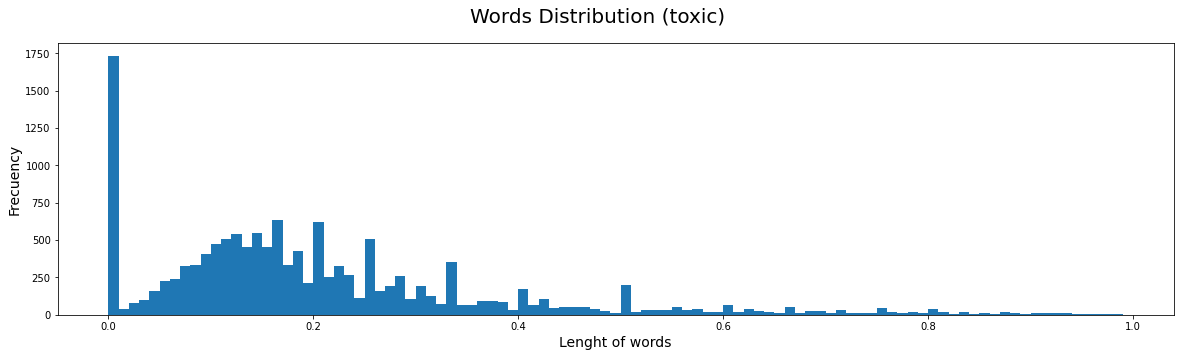

In [160]:
fig= plt.figure(figsize=(20,5))
fig.suptitle('Words Distribution (toxic)', fontsize=20)
plt.xlabel('Lenght of words', fontsize=14)
plt.ylabel('Frecuency', fontsize=14)
plt.hist(T_words,bins = np.arange(0,1,0.01))
plt.show()

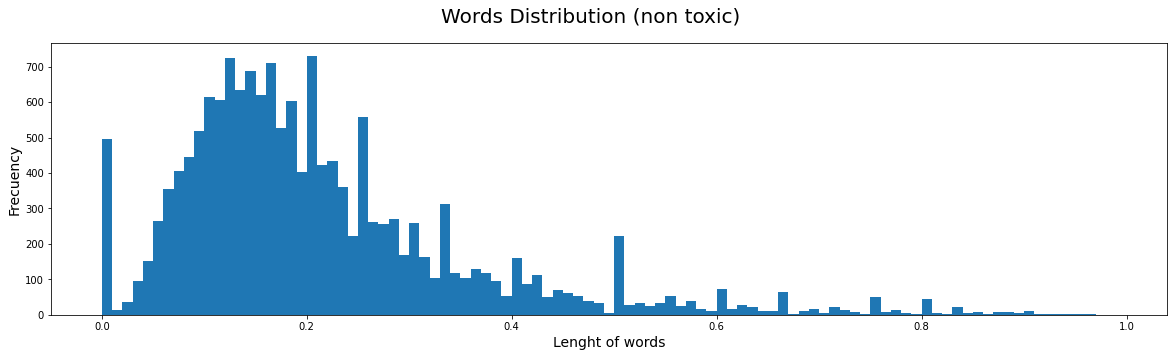

In [161]:
fig= plt.figure(figsize=(20,5))
fig.suptitle('Words Distribution (non toxic)', fontsize=20)
plt.xlabel('Lenght of words', fontsize=14)
plt.ylabel('Frecuency', fontsize=14)
plt.hist(N_words,bins = np.arange(0,1,0.01))
plt.show()

The are more words with capital letter in the non_toxic set, we can see much more comments with zero capital letters in the toxic set

## Distribution of unique words

In [140]:
P_words = toxic['comment_text'].apply(lambda comment: 
                                          len(comment.split())/ len(set(w for w in comment.split()))) 
# Positive words
N_words = non_toxic['comment_text'].apply(lambda comment: 
                                          len(comment.split())/ len(set(w for w in comment.split())))

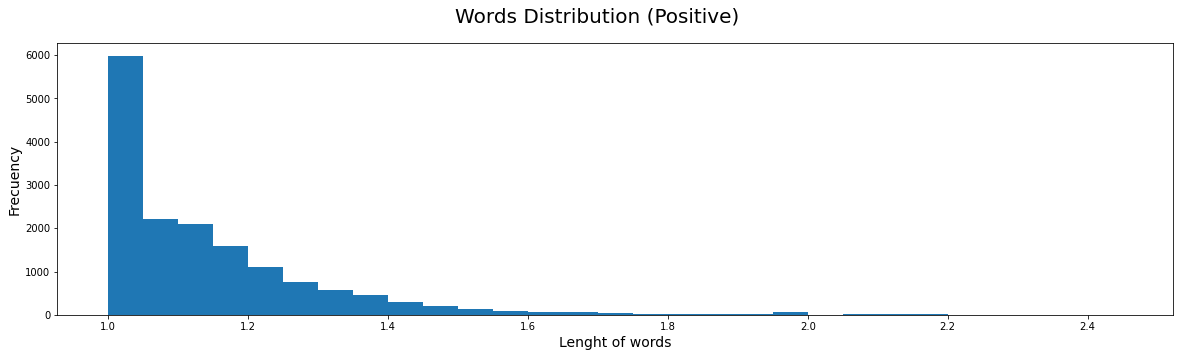

In [148]:
fig= plt.figure(figsize=(20,5))
fig.suptitle('Words Distribution (Positive)', fontsize=20)
plt.xlabel('Lenght of words', fontsize=14)
plt.ylabel('Frecuency', fontsize=14)
plt.hist(P_words,bins = np.arange(1,2.5,0.05))
plt.show()

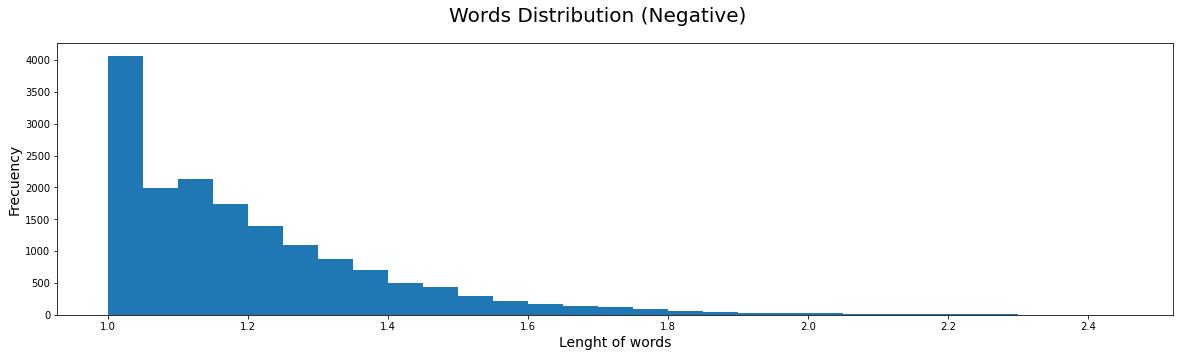

In [149]:
fig= plt.figure(figsize=(20,5))
fig.suptitle('Words Distribution (Negative)', fontsize=20)
plt.xlabel('Lenght of words', fontsize=14)
plt.ylabel('Frecuency', fontsize=14)
plt.hist(N_words,bins = np.arange(1,2.5,0.05))
plt.show()

In [150]:
Qtoxic = toxic['comment_text'].apply(lambda comment: comment.count('?'))
Qmon_toxic = non_toxic['comment_text'].apply(lambda comment: comment.count('?'))
print(exp.sum(),exn.sum())
# question mark is more common in toxic comments

9541 6864


In [158]:
Ftoxic = toxic['comment_text'].apply(lambda comment: comment.count('fuck') )
Fnontoxic = non_toxic['comment_text'].apply(lambda comment: comment.count('fuck'))
print(exp.sum(),exn.sum())
# the use of the word "fuck" is much more frequent in the toxic comments

9075 26


# Preprocessing

In [6]:
def Features(df):
    capital=df['comment_text'].apply(lambda comment: 
                                       sum(1 for c in comment if c.isupper())/len(comment.split()))
    questions = df['comment_text'].apply(lambda comment: comment.count('?'))
    F_word = df['comment_text'].apply(lambda comment: comment.count('fuck') )
    return capital, questions, F_word
capital, questions, F_word = Features(df)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [175]:
special_chars = r"[^a-z@#\$%\^\&\*_\-,\.' ]ðÿœžðÿâœœïÿœžÿºÿÿœžÿ"

RE_PATTERNS = {
    ' fuck':['(f)([^a-z]*)(u)([^a-z]*)(c)([^a-z]*)(k)','(f)(u|[^a-z0-9 ])(c|[^a-z0-9 ])(k|[^a-z0-9 ])([^ ])*',
            'feck ', ' fux ', 'f\*\*', 'f\-ing', 'f u u c', '(f)(c|[^a-z ])(u|[^a-z ])(k)', r'f\*',' fu ',
            'f[!@#\$%\^\&\*]*u[!@#\$%\^&\*]*k', 'f\.u\.', 'f###', 'f@ck', 'f u c k', 'f uck', 'f ck' ],
    ' ass ':['[^a-z]ass ', '[^a-z]azz ', 'arrse', ' arse ', '@\$\$', '[^a-z]anus', ' a\*s\*s', 
        '[^a-z]ass[^a-z ]', 'a[@#\$%\^&\*][@#\$%\^&\*]', '[^a-z]anal ', 'a s s'],
    ' ass hole ':[' a[s|z]*wipe', 'a[s|z]*[w]*h[o|0]+[l]*e', '@\$\$hole'],
    ' bitch ':['(b)([^a-z]*)(i)([^a-z]*)(t)([^a-z]*)(c)([^a-z]*)(h)', 'b!tch','bi\+ch', 'b!\+ch',
               'b[w]*i[t]*ch','biatch', 'bi\*\*h', 'bytch', 'b i t c h'],
    ' bastard ':['ba[s|z]+t[e|a]+rd'],
    ' dick ':[' dick[^aeiou]', 'deek', 'd i c k'],
    ' suck ':[ 'sucker', '(s)([^a-z ]*)(u)([^a-z ]*)(c)([^a-z ]*)(k)', 'sucks', '5uck', 's u c k'],
    ' cunt ':['c u n t'],
    ' bull shit ':[ 'bullsh\*t', 'bull\$hit'],
    ' idiot ':['i[d]+io[t]+', '(i)([^a-z ]*)(d)([^a-z ]*)(i)([^a-z ]*)(o)([^a-z ]*)(t)','idiots','i d i o t'],
    ' cock ':['[^a-z]cock', 'c0ck', '[^a-z]cok ', 'c0k', '[^a-z]cok[^aeiou]', ' cawk',
            '(c)([^a-z ])(o)([^a-z ]*)(c)([^a-z ]*)(k)', 'c o c k'],
    ' dumb ':['(d)([^a-z ]*)(u)([^a-z ]*)(m)([^a-z ]*)(b)'],
    ' shit ':['shitty', '(s)([^a-z ]*)(h)([^a-z ]*)(i)([^a-z ]*)(t)', 'shite', '\$hit', 's h i t'],
    ' shit hole ':['shythole'],
    ' retard ':['returd', 'retad', 'retard', 'wiktard', 'wikitud'],
    ' rape ':['raped'],
    ' dumb ass':['dumbass', 'dubass'],
    ' ass head':['butthead'],
    ' nigger ':['nigger', 'ni[g]+a', ' nigr ', 'negrito', 'niguh', 'n3gr', 'n i g g e r'],
    ' shut the fuck up': ['stfu'],
    ' pussy ': ['pussy[^c]', 'pusy', 'pussi[^l]', 'pusses'],
    ' faggot ':['faggot', ' fa[g]+[s]*[^a-z ]', 'fagot', 'f a g g o t', 'faggit',
            '(f)([^a-z ]*)(a)([^a-z ]*)([g]+)([^a-z ]*)(o)([^a-z ]*)(t)', 'fau[g]+ot', 'fae[g]+ot',],
    ' mother fucker':[' motha ', ' motha f', ' mother f', 'motherucker'],
    ' whore ':['wh\*\*\*', 'w h o r e'],
    ' link ':['h[\S]+//[\S]+']
}

In [178]:
class preprocessing(object):
    def __init__(self,special_chars, pattern):
        self.pattern = pattern
        self.special_chars = special_chars

    def cleanString(self,s):
        # remove special chars
        for char in self.special_chars:
            s = s.replace(char, "")
        s = s.replace("\\n", " ").replace("\n", " ")
        s=s.lower()
        #remove non-ascii and digits
        s=re.sub("(\\W|\\d)"," ",s)
        # Regular expressions
        pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
        s = pattern.sub(r"\1", s)
        tokenizer = TweetTokenizer()
        # Remove stop words
        stop_words = set(stopwords.words('english'))
        cleaned_words = [w for w in tokenizer.tokenize(s) if w not in stop_words]
        return " ".join(cleaned_words)

    def stemWords(self,sentence):
        stemmer, tokenizer = PorterStemmer(), TweetTokenizer()
        stemmed_words = [stemmer.stem(w) for w in tokenizer.tokenize(sentence)]
        return " ".join(stemmed_words)

    def cleanFrame(selfdev,frame):
        frame['clean_comment'] = frame.comment_text.apply(selfdev.cleanString)

    def stemFrame(selfdev,frame):
        frame['stem_comment'] = frame.clean_comment.apply(selfdev.stemWords)


In [179]:
Preprocessing=preprocessing(special_chars, RE_PATTERNS)
Preprocessing.cleanFrame(df)
Preprocessing.stemFrame(df)

In [181]:
df.sample(5)

,id,comment_text,Toxic,clean_comment,stem_comment
76446,ccaa43c55a4995b2,"""\n\nSynthesis as per wikipedia means If one r...",0,synthi pr ikipdia man rliabl ourc ay anothr rl...,synthi pr ikipdia man rliabl ourc ay anothr rl...
141398,f4709f76c13ece4c,"""\n\n excessively long / appositive commaS \n\...",0,xcily lon appoiti commas thi articl xcily lon ...,xcili lon appoiti comma thi articl xcili lon h...
124687,9b0a2df4f7cd4131,Lyrics\nThis is probably not the place for a g...,0,lyric thi probably th plac rat dbat hy arnt ly...,lyric thi probabl th plac rat dbat hy arnt lyr...
53324,8e8832b78f5efc93,"Hello, and welcome to Wikipedia! We appreciate...",0,hllo lcom wikipdia w apprciat contribution th ...,hllo lcom wikipdia w apprciat contribut th ran...
53885,8ff6a95442291de6,"""Proposal for renaming ==\n\nThis article refe...",0,propoal rnamin thi articl rfr th n world ordr ...,propoal rnamin thi articl rfr th n world ordr ...


# Save data in a pickle

In [182]:
import pickle
path='../data/jigsaw-toxic-comment-classification-challenge/'
toxic_comments_file = open(path+'toxic.pickle','wb') 
toxic_comments = df
pickle.dump(toxic_comments, toxic_comments_file)

# Load data

In [2]:
path='../data/jigsaw-toxic-comment-classification-challenge/'
import pickle
toxic_comments = open(path + 'toxic.pickle','rb') 
data = pickle.load(toxic_comments)
data.sample(5)

,id,comment_text,Toxic,clean_comment,stem_comment
80262,d6b88c6e396fe7ff,"""\nAlso, please read Username policy and consi...",0,alo pla rad urnam policy conidr chanin urnam t...,alo pla rad urnam polici conidr chanin urnam t...
6883,12632af15257fc51,"Stalinácio Lula da Silva, by your signature we...",0,stalinácio lula da sila inatur tll ho biad ar ...,stalinácio lula da sila inatur tll ho biad ar ...
80673,d7d57037d64d04c6,REMOVING IRRELEVANT NONSENSE\n\nAD HOMINEM ATT...,1,removing irrelevant nonsense ad hominem attack...,remov irrelev nonsens ad hominem attack place ...
24257,400e48d8779316c4,I believe that you don't have a fucking clue w...,1,bli dont ha fuckin clu hat talkin fatuorum,bli dont ha fuckin clu hat talkin fatuorum
89315,eee9c3a1c6d43749,"""\nNew Zealand has a different approach: this ...",0,n zaland ha diffrnt approach thi uy th hihtpai...,n zaland ha diffrnt approach thi uy th hihtpai...


In [3]:
len(data)

159571

In [41]:
data=data.sample(1000)

In [13]:
def Lexico(tokens, Lexico):
    for word in tokens:
        if word in Lexico.keys():
            Lexico[word] += 1
        else:
            Lexico[word] = 1
    return Lexico
lexico={}
tokenizer = nltk.tokenize.TweetTokenizer()

for text in data["stem_comment"]:
    tokens = tokenizer.tokenize((" ".join(text)))
    lexico.update(Lexico(tokens,lexico))

In [14]:
len(lexico)

6973

In [16]:
bag_words=set(lexico.keys())

In [40]:
classes=data["Toxic"].values

In [42]:
Vectors_no_features = pd.DataFrame(data = lexico, columns = bag_words)


In [31]:
Vectors = pd.DataFrame(data = lexico, columns = bag_words)
Vectors['Capital']=capital
Vectors['Questions']=questions
Vectors['F_word']=F_word

In [32]:
Vectors

,mot,janic,ction,arrin,mntal,tur,bioraphi,cunnin,qualiti,dpartmnt,...,commnti,miin,intrior,ninrin,rmain,alntino,dirctly,Capital,Questions,F_word
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.395349,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.470588,0,0
2,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.095238,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0.097345,0,0
4,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.153846,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.197183,0,0
996,0,0,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.292135,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.154639,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.079096,0,0


# Logistic Regression

In [52]:
class Logistic_regression:
    def __init__(self, lr,num_iter):
        self.num_iter = num_iter
        self.lr = lr
    def bias_init(self, X):
        #This fucntions is to set the bias and concatenate it on the matrix X (X_test)
        bias = np.ones((X.shape[0], 1))
        return np.concatenate((bias, X), axis=1)
    def weight_init(self, X):
        #Here we start all the weights to 0
        return np.zeros(X.shape[1])
    def CrossEntropy(self,h,y):
        #Loss function (cross entropy)
        loss=0
        for i in range(len(y)):
            if y[i]==0:
                loss+= log(1-h[i])
            else:
                loss+= log(h[i])
        return loss
    def gradient_descent(self, x, y, yhat):
        # We compute the descendent gradient
        return np.dot(x.T, (yhat - y))/y.size
    def optimize(self, x, y, yhat, theta):
        # We update the weights
        # This is done by the use of gradient and learning rate
        gradient = self.gradient_descent(x, y, yhat)
        theta -= self.lr * gradient
        return theta
    def activation_sigmoid(self, z):
        #We activate by the sigmoidal function
        return 1 / (1 + np.exp(-z))
    def predict(self, X):
        #Predict the values by using activation function
        X = self.bias_init(X)
        pred = self.activation_sigmoid(np.dot(X, self.theta))
        return pred.round()
    def fit(self, X, y):
        # Set bias
        X = self.bias_init(X)
        # Here we are going to start the weights
        self.theta = self.weight_init(X)
        for i in range(self.num_iter):
            #dot product of X and weights to get z
            z = np.dot(X, self.theta)
            # predicted
            h = self.activation_sigmoid(z)
            #update the weights
            self.theta = self.optimize(X, y, h, self.theta)
            loss=  self.CrossEntropy(h,y)
            #print(f'loss: {loss} \t')

In [58]:
from sklearn.utils import shuffle
shuffle(X_train,y_train)

def K_fold(X, y, k):
    X, y = shuffle(X, y)
    left_overs = {}
    sets = []
    max_accu = 0
    matrix = []
    report = []
    accuracy = []
    best_set = -1
    n_left_overs = (len(y) % k)
    if n_left_overs != 0:
        left_overs["X"] = X[-n_left_overs:]
        left_overs["y"] = y[-n_left_overs:]
        X = X[:-n_left_overs]
        y = y[:-n_left_overs]

    X_split = np.split(X, k)
    y_split = np.split(y, k)
    
    for i in range(k):
        X_test, y_test = X_split[i], y_split[i]
        X_train = np.concatenate(X_split[:i] + X_split[i + 1:], axis=0)
        y_train = np.concatenate(y_split[:i] + y_split[i + 1:], axis=0)
        
        log_reg = Logistic_regression(lr = 0.0001, num_iter = 1000)
        log_reg.fit(X_train, y_train)
        predictions = log_reg.predict(X_test)
        matrix.append(confusion_matrix(y_test,predictions))  
        report.append(classification_report(y_test,predictions))  
        accuracy.append(accuracy_score(y_test, predictions))
        
        if accuracy_score(y_test, predictions) > max_accu:
            max_accu = accuracy_score(y_test, predictions)
            best_set = i
        sets.append([X_train, X_test, y_train, y_test])
    if n_left_overs != 0:
        np.append(sets[-1][0], left_overs["X"], axis=0)
        np.append(sets[-1][2], left_overs["y"], axis=0)

    return best_set, matrix, report , accuracy

In [61]:
best_set, matrix, report, accuracy = K_fold(Vectors_no_features, classes, 5)

/home/cj/.local/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [62]:
print(matrix[best_set])

[[181   0]
 [ 19   0]]


In [63]:
print(report[best_set])

              precision    recall  f1-score   support

           0       0.91      1.00      0.95       181
           1       0.00      0.00      0.00        19

    accuracy                           0.91       200
   macro avg       0.45      0.50      0.48       200
weighted avg       0.82      0.91      0.86       200



In [64]:
print(accuracy[best_set])

0.905


In [65]:
best_set, matrix, report, accuracy = K_fold(Vectors, classes, 5)

In [66]:
print(report[best_set])
print(matrix[best_set])
print(accuracy[best_set])

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       183
           1       0.00      0.00      0.00        17

    accuracy                           0.92       200
   macro avg       0.46      0.50      0.48       200
weighted avg       0.84      0.92      0.87       200

[[183   0]
 [ 17   0]]
0.915


# Balanced Classes

In [84]:
balanced=data.sample(10000)

In [85]:
toxic, non_toxic = makingClasses(balanced)

Toxic: 1050 10.5%
Non toxic: 8950 89.5%


In [86]:
non_toxic=non_toxic.sample(len(toxic))

In [92]:
data_balanced=pd.concat([toxic,non_toxic])

In [94]:
len(data_balanced)

2100

In [71]:
def Lexico(tokens, Lexico):
    for word in tokens:
        if word in Lexico.keys():
            Lexico[word] += 1
        else:
            Lexico[word] = 1
    return Lexico
lexico_balanced={}
tokenizer = nltk.tokenize.TweetTokenizer()

for text in data_balanced["stem_comment"]:
    tokens = tokenizer.tokenize(("".join(text)))
    lexico_balanced.update(Lexico(tokens,lexico_balanced))
bag_words = set(lexico_balanced)

In [118]:
Vectors_balanced = pd.DataFrame(data = lexico_balanced, columns = bag_words)
capital, questions, F_word = Features(data_balanced)
Vectors_balanced['Capital']=capital
Vectors_balanced['Questions']=questions
Vectors_balanced['F_word']=F_word

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [122]:
classes_balanced=data_balanced["Toxic"].values

In [129]:
best_set, matrix, report, accuracy = K_fold(Vectors_balanced2, classes_balanced, 5)
print(report[best_set])
print(matrix[best_set])
print(accuracy[best_set])

              precision    recall  f1-score   support

           0       0.64      0.92      0.75       206
           1       0.86      0.50      0.63       214

    accuracy                           0.70       420
   macro avg       0.75      0.71      0.69       420
weighted avg       0.75      0.70      0.69       420

[[189  17]
 [107 107]]
0.7047619047619048
